In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

with open('train_feature.npy', 'rb') as f:
    train_feature = np.load(f)
with open('train_label.npy', 'rb') as f:
    train_label = np.load(f)
with open('test_feature.npy', 'rb') as f:
    test_feature = np.load(f)

In [2]:
# Calc the mean of every pixel across all frames
x_TrainData = np.mean(train_feature, axis = 1)
x_TestData = np.mean(test_feature, axis = 1)

# reshape to 1d array
y_TrainData = train_label.ravel()

# Make grid to find the best parameters for this model
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], # C values
    'kernel': ['linear','rbf', 'poly'], # Kernels 
    'degree': [3, 4, 5], # potential 'poly' degrees
    'gamma': ['scale','auto'] # Kernel coeffs
}
# Create and use grid search to find the best parameters
grid_Search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_Search.fit(x_TrainData, y_TrainData)

print("Best Parameters to use are:", grid_Search.best_params_)

Best Parameters to use are: {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}


In [3]:
chosen_C = 10
chosen_degree = 3
chosen_gamma = 'auto'
chosen_kernel = 'rbf'

# Create model for 2.1
p2_1_svc = SVC(C=chosen_C, kernel=chosen_kernel, degree=chosen_degree, gamma=chosen_gamma, probability=True)

# Create pipeline
p2_1_model = Pipeline([
    ('scaler', StandardScaler()),
    ('SVC', p2_1_svc)
])

# fit 2.1 Model
p2_1_model.fit(x_TrainData, y_TrainData)

# Test
predictions = p2_1_model.predict(x_TestData)

# Convert to ints
predictions = predictions.astype(np.int64)

In [5]:
# convert predictions to binary
predictions[predictions!=11] = 0
predictions[predictions==11] = 1

# Create submission file and export
submission = pd.DataFrame ({
    'id': np.arange(len(predictions)),
    'Predictions': predictions
})

submission.head()

submission.to_csv('SMDost_part_2_1_submission.csv', index=False)

In [6]:
# logistic regression multi-class

# Split the training data into training and testing sets
x_TrainData, x_TestData, y_TrainData, y_TestData = train_test_split(train_feature, train_label, random_state=2)

# Reshape the training data
x_TrainData_reshaped = x_TrainData.reshape(x_TrainData.shape[0], -1)

# Define the pipeline for preprocessing and logistic regression model
pipeline = Pipeline([('scalar', StandardScaler), ('lor', LogisticRegression)])

# Define hyperparameter grid for logistic regression
param_grid = [
  {'C': [1e-7, 1e-5, 0.01, 0.1, 1],
   'max_iter': [500]}
]

# Initialize logistic regression model
log_Reg = LogisticRegression()

# Perform grid search cross-validation to find the best hyperparameters
log_Reg_cv = GridSearchCV(log_Reg, param_grid, cv=3)
log_Reg_cv.fit(x_TrainData_reshaped, y_TrainData)

# Print the best hyperparameters found
print(log_Reg_cv.best_params_)

{'C': 1, 'max_iter': 500}


In [7]:
# Reshape the test data
x_TestData_reshaped = x_TestData.reshape(x_TestData.shape[0], -1)

# Make predictions on the test data
y_pred = log_Reg_cv.predict(x_TestData_reshaped)

# Calculate accuracy of the model
accuracy = accuracy_score(y_TestData, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

# Reshape the entire training data
tfeatures_reshaped = train_feature.reshape(train_feature.shape[0], -1)

# Fit the logistic regression model on the entire training data
log_Reg_cv.fit(tfeatures_reshaped, train_label)

# Reshape the test data for prediction
test_feature_reshaped = test_feature.reshape(test_feature.shape[0], -1)

# Make predictions on the test data
ypred = log_Reg_cv.predict(test_feature_reshaped)

# Create a DataFrame for submission with 'id' and 'predicted' as column names
p_2_2_submission = pd.DataFrame({
    'id':list(range(969)),
    'predicted':list(ypred.astype('int32'))
})

# Display the first few rows of the submission DataFrame
p_2_2_submission.head()

# Export the submission DataFrame to a CSV file
submission.to_csv('SMDost_part_2_2_submission.csv', index=False)

Accuracy: 0.9592529711375212


In [9]:
# split into Validation and Train set
x_tData, x_ValidData, y_tData, y_ValidData = train_test_split(train_feature, train_label, random_state=None,shuffle=False)

# Reshape the training+valid data
x_tData_reshaped = x_tData.reshape(x_tData.shape[0], -1)
x_ValidData_reshaped = x_ValidData.reshape(x_ValidData.shape[0], -1)

# Fit the logistic regression model on the entire training data
log_Reg_cv.fit(x_tData_reshaped, y_tData)

# Make prediction and find accuracy
y_pred = log_Reg_cv.predict(x_ValidData_reshaped)

accuracy = accuracy_score(y_ValidData, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.028862478777589132


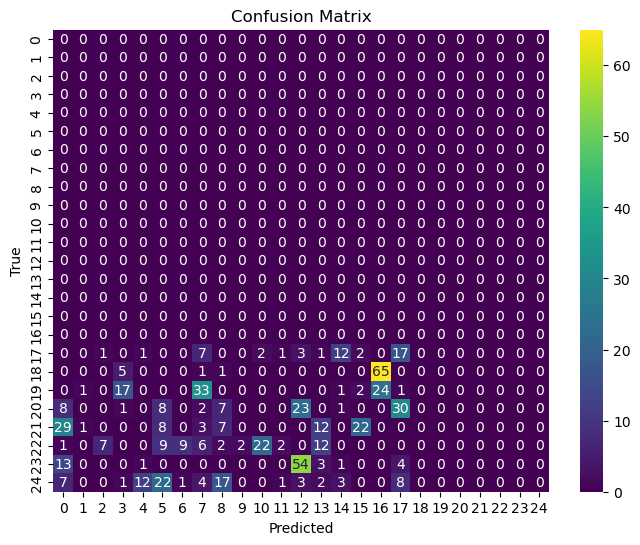

In [66]:
# Calculate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_ValidData, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Can't get to the gif to show even with helps of TA, chatGPT, and https://trac.ffmpeg.org/ :/
import os
os.environ['IMAGEIO_FFMPEG_EXE'] = '/usr/bin/ffmpeg'
from moviepy.editor import VideoFileClip

train_df = pd.read_csv("train.csv")

def video_to_gif(video_filename):
    videoClip = VideoFileClip(video_filename)
    gif_filename = '{0}.gif'.format(video_filename.split('/')[1])
    videoClip.write_gif(gif_filename)
    return gif_filename

from IPython.display import Image
sample_filename = '/'.join(['train', train_df.loc[100, 'video_name']])
print(train_df.loc[100, 'tag'])
print(sample_filename)
gif_filename = video_to_gif(sample_filename) # convert an .avi file into a .gif file.
Image(open(gif_filename,'rb').read()) # display the gif file.

SyntaxError: invalid syntax (1964741931.py, line 1)